<a href="https://colab.research.google.com/github/rmartinshort/FruitClassification/blob/master/Apple_Classifier_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Building a CNN with Keras to classify types of apples

These apple images come from the fruits-360 database. We are attempting to classify fruits into 13 different types of apple or 'other', meaning not one of the 13 types. Hopefully something similar can be done with Ehime oranges once we have a dataset. 

This is using transfer learning from VGG16, trained on imagenet. Other networks trained on other datasets are possible and could be investigated too

In [0]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import backend as K
from keras.callbacks import TensorBoard
from keras import optimizers
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.multiclass import unique_labels

from PIL import Image
import matplotlib.pyplot as plt
import glob
import numpy as np

In [2]:
if K.backend() == "tensorflow":
    device_name = tf.test.gpu_device_name()
    if device_name == '':
        device_name = "None"
    print('Using TensorFlow version:', tf.__version__, ', GPU:', device_name)

Using TensorFlow version: 1.14.0 , GPU: /device:GPU:0


In [3]:
!unzip apples_for_CNN.zip

Archive:  apples_for_CNN.zip
   creating: apples_for_CNN/
   creating: apples_for_CNN/holdout/
   creating: apples_for_CNN/holdout/Apple_Red_Delicious/
  inflating: apples_for_CNN/holdout/Apple_Red_Delicious/r_150_100.jpg  
  inflating: apples_for_CNN/holdout/Apple_Red_Delicious/18_100.jpg  
  inflating: apples_for_CNN/holdout/Apple_Red_Delicious/235_100.jpg  
  inflating: apples_for_CNN/holdout/Apple_Red_Delicious/300_100.jpg  
  inflating: apples_for_CNN/holdout/Apple_Red_Delicious/310_100.jpg  
  inflating: apples_for_CNN/holdout/Apple_Red_Delicious/r_313_100.jpg  
  inflating: apples_for_CNN/holdout/Apple_Red_Delicious/27_100.jpg  
  inflating: apples_for_CNN/holdout/Apple_Red_Delicious/11_100.jpg  
  inflating: apples_for_CNN/holdout/Apple_Red_Delicious/295_100.jpg  
  inflating: apples_for_CNN/holdout/Apple_Red_Delicious/r_13_100.jpg  
  inflating: apples_for_CNN/holdout/Apple_Red_Delicious/r_149_100.jpg  
  inflating: apples_for_CNN/holdout/Apple_Red_Delicious/138_100.jpg  
  in

Specify the locations of the training and validation datasets, and the sizes of the images to be trained on. These sizes are determined by the input to VGG16

In [0]:
train_dir = 'apples_for_CNN/train/'
val_dir = 'apples_for_CNN/val'
holdout_dir = 'apples_for_CNN/holdout'
BATCH_SIZE = 20
HEIGHT = 224
WIDTH = 224 
N_EPOCHS = 30

In [5]:
#Load the base model 
base_model = VGG16(weights='imagenet',include_top=False,input_shape=(HEIGHT,WIDTH,3))

W0727 17:02:56.058242 139668078491520 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0727 17:02:56.064171 139668078491520 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0727 17:02:56.073413 139668078491520 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0727 17:02:56.113769 139668078491520 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



58892288/58889256 [==============================] - 2s 0us/step


W0727 17:02:59.114850 139668078491520 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0727 17:02:59.116054 139668078491520 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



In [0]:
#Image augmentation for the training dataset. This could be adjusted to improve accurcy and prevent overfitting
#Remember to rescale the image!!

datagen_train = ImageDataGenerator(     
    rescale=1. / 255,
    horizontal_flip=True,
    rotation_range=90,
    fill_mode = "nearest",
    zoom_range = 0.3,
    width_shift_range = 0.3,
    height_shift_range=0.3,
    vertical_flip=True)

#Image processing only for the test dataset
datagen_val = ImageDataGenerator(
        rescale=1. / 255)

In [7]:
train_generator = datagen_train.flow_from_directory(train_dir,\
target_size=(HEIGHT,WIDTH),batch_size=BATCH_SIZE,class_mode='categorical',shuffle=True)


Found 4851 images belonging to 14 classes.


In [8]:
test_generator = datagen_val.flow_from_directory(val_dir,\
    target_size=(HEIGHT,WIDTH),class_mode='categorical',shuffle=False)

Found 2068 images belonging to 14 classes.


In [23]:
holdout_generator = datagen_val.flow_from_directory(holdout_dir,\
    target_size=(HEIGHT,WIDTH),class_mode='categorical',shuffle=False)

Found 2339 images belonging to 14 classes.


In [0]:
#Dictionary of class labels to use
classes_dict = train_generator.class_indices

In [11]:
#Here are the classes and their numerical encodings
classes_dict

{'Apple_Braeburn': 0,
 'Apple_Crimson_Snow': 1,
 'Apple_Golden_1': 2,
 'Apple_Golden_2': 3,
 'Apple_Golden_3': 4,
 'Apple_Granny_Smith': 5,
 'Apple_Pink_Lady': 6,
 'Apple_Red_1': 7,
 'Apple_Red_2': 8,
 'Apple_Red_3': 9,
 'Apple_Red_Delicious': 10,
 'Apple_Red_Yellow_1': 11,
 'Apple_Red_Yellow_2': 12,
 'Other': 13}

In [0]:
def build_finetune_model(base_model, dropout, fc_layers, num_classes):
  
    ''' This generates a model whose final layer can be retrained as in transfer
    learning '''
    
    
    #Prevent the CNN layers from being trainable
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = Flatten()(x)
    for fc in fc_layers:
        # New FC layer, random init
        x = Dense(fc, activation='relu')(x) 
        x = Dropout(dropout)(x)

    # New softmax layer
    predictions = Dense(num_classes, activation='softmax')(x) 
    
    finetune_model = Model(inputs=base_model.input, outputs=predictions)

    return finetune_model
 

def load_image(img_path, show=False):
  
    '''Load an image for viewing'''

    img = load_img(img_path, target_size=(HEIGHT, WIDTH))
    img_tensor = img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]

    if show:
        plt.imshow(img_tensor[0])                           
        plt.axis('off')
        plt.show()

    return img_tensor

In [0]:
#A list of the class names
class_list = sorted(glob.glob('apples_for_CNN/train/*'))
classes = [x.split('/')[-1] for x in class_list]

In [0]:
FC_LAYERS = [4096,4096]

#May want to use dropout to reduce overfitting, but we can experiment with this
dropout = 0

final_model = build_finetune_model(base_model, 
                                      dropout=dropout, 
                                      fc_layers=FC_LAYERS, 
                                      num_classes=len(class_list))

In [15]:
#Here is the model
final_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [16]:
# compile the model 
final_model.compile(loss = "categorical_crossentropy", optimizer = optimizers.Adam(lr=0.0001), metrics=["accuracy"])

W0727 17:03:32.135440 139668078491520 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [17]:
#Train the model

step_size_train=train_generator.n//train_generator.batch_size
step_size_test=test_generator.n//test_generator.batch_size

with tf.device("/device:GPU:0"):
    history_pretrained = final_model.fit_generator(
    train_generator,
    epochs=N_EPOCHS, 
    shuffle = True, 
    verbose = 1,
    steps_per_epoch=step_size_train,
    validation_data = test_generator, 
    validation_steps=step_size_test)

W0727 17:03:36.941679 139668078491520 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/30
242/242 [==============================] - 82s 341ms/step - loss: 1.8772 - acc: 0.4052 - val_loss: 1.0275 - val_acc: 0.6709
Epoch 2/30
242/242 [==============================] - 71s 292ms/step - loss: 0.9411 - acc: 0.6752 - val_loss: 0.7090 - val_acc: 0.7308
Epoch 3/30
242/242 [==============================] - 69s 286ms/step - loss: 0.7818 - acc: 0.7132 - val_loss: 0.5552 - val_acc: 0.8173
Epoch 4/30
242/242 [==============================] - 70s 288ms/step - loss: 0.6852 - acc: 0.7578 - val_loss: 0.3922 - val_acc: 0.8689
Epoch 5/30
242/242 [==============================] - 69s 287ms/step - loss: 0.5827 - acc: 0.7927 - val_loss: 0.2935 - val_acc: 0.9096
Epoch 6/30
242/242 [==============================] - 69s 286ms/step - loss: 0.5310 - acc: 0.8135 - val_loss: 0.3836 - val_acc: 0.8723
Epoch 7/30
242/242 [==============================] - 69s 287ms/step - loss: 0.5087 - acc: 0.8211 - val_loss: 0.3594 - val_acc: 0.8566
Epoch 8/30
242/242 [==============================] - 7

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


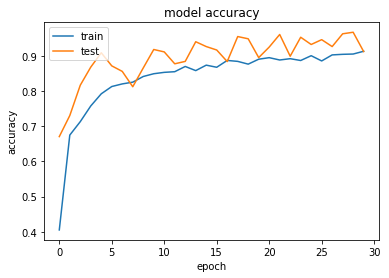

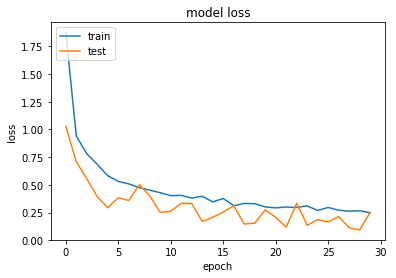

In [18]:
#Lets take look at the evolution of the validation error over time

# list all data in history
print(history_pretrained.history.keys())
# summarize history for accuracy
plt.plot(history_pretrained.history['acc'])
plt.plot(history_pretrained.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_pretrained.history['loss'])
plt.plot(history_pretrained.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Assessment on the holdout dataset

In [43]:
fruits_accuracy_dict = classes_dict.copy()

true_classes = []
predicted_classes = []

for fruit in classes_dict:
  
  print(f'Dealing with fruit {fruit}')
  
  #get the known class
  correct_class = classes_dict[fruit]
  
  correct_classes = 0
  i = 0
  
  for test_image in glob.glob('apples_for_CNN/holdout/%s/*' %fruit):
    
    input_image = load_image(test_image,show=False)
    # check prediction
    pred = final_model.predict(input_image)
    #get the class
    myclass = np.argmax(pred)
    
    true_classes.append(correct_class)
    predicted_classes.append(myclass)
    
    if myclass == correct_class:
      correct_classes += 1

    i+=1
   
  fruits_accuracy_dict[fruit] = correct_classes/i

Dealing with fruit Apple_Braeburn
Dealing with fruit Apple_Crimson_Snow
Dealing with fruit Apple_Golden_1
Dealing with fruit Apple_Golden_2
Dealing with fruit Apple_Golden_3
Dealing with fruit Apple_Granny_Smith
Dealing with fruit Apple_Pink_Lady
Dealing with fruit Apple_Red_1
Dealing with fruit Apple_Red_2
Dealing with fruit Apple_Red_3
Dealing with fruit Apple_Red_Delicious
Dealing with fruit Apple_Red_Yellow_1
Dealing with fruit Apple_Red_Yellow_2
Dealing with fruit Other


In [44]:
fruits_accuracy_dict

{'Apple_Braeburn': 0.9939024390243902,
 'Apple_Crimson_Snow': 0.9256756756756757,
 'Apple_Golden_1': 0.9939024390243902,
 'Apple_Golden_2': 0.8292682926829268,
 'Apple_Golden_3': 0.37267080745341613,
 'Apple_Granny_Smith': 1.0,
 'Apple_Pink_Lady': 0.6973684210526315,
 'Apple_Red_1': 0.9939024390243902,
 'Apple_Red_2': 0.9817073170731707,
 'Apple_Red_3': 1.0,
 'Apple_Red_Delicious': 1.0,
 'Apple_Red_Yellow_1': 0.6890243902439024,
 'Apple_Red_Yellow_2': 1.0,
 'Other': 0.8805970149253731}

In [21]:
#This is the mean accuracy on the holdout dataset - not bad!
np.mean(list(fruits_accuracy_dict.values()))

0.8827156597271619

In [0]:
output_classes = list(holdout_generator.class_indices.keys())

In [49]:
#Confusion Matrix and Classification Report

print('Confusion Matrix')
print(confusion_matrix(np.array(true_classes), np.array(predicted_classes)))


print('Classification Report')
print(classification_report(np.array(true_classes), np.array(predicted_classes), target_names=output_classes))

Confusion Matrix
[[163   0   0   0   0   0   0   0   1   0   0   0   0   0]
 [ 11 137   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0 163   0   0   0   0   0   0   0   0   0   0   1]
 [  0   0   0 136   0  28   0   0   0   0   0   0   0   0]
 [  0   0   0   0  60 101   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0 164   0   0   0   0   0   0   0   0]
 [  0   2   0   0   0  11 106   0   4   0   0   0  20   9]
 [  1   0   0   0   0   0   0 163   0   0   0   0   0   0]
 [  0   0   0   0   1   1   0   0 161   0   0   0   0   1]
 [  0   0   0   0   0   0   0   0   0 144   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0 166   0   0   0]
 [  0   0   1  10   0   0   0   0  33   0   0 113   0   7]
 [  0   0   0   0   0   0   0   0   0   0   0   0 219   0]
 [  2   2   0   0   3   8   0   0   2   1   1   1   4 177]]
Classification Report
                     precision    recall  f1-score   support

     Apple_Braeburn       0.92      0.99      0.96       164
 Apple_Crim

In [39]:
y_pred

array([10, 10, 10, ..., 10, 10, 10])

In [42]:
holdout_generator.classes

array([ 0,  0,  0, ..., 13, 13, 13], dtype=int32)

In [0]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Confusion matrix, without normalization
[[163   0   0   0   0   0   0   0   1   0   0   0   0   0]
 [ 11 137   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0 163   0   0   0   0   0   0   0   0   0   0   1]
 [  0   0   0 136   0  28   0   0   0   0   0   0   0   0]
 [  0   0   0   0  60 101   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0 164   0   0   0   0   0   0   0   0]
 [  0   2   0   0   0  11 106   0   4   0   0   0  20   9]
 [  1   0   0   0   0   0   0 163   0   0   0   0   0   0]
 [  0   0   0   0   1   1   0   0 161   0   0   0   0   1]
 [  0   0   0   0   0   0   0   0   0 144   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0 166   0   0   0]
 [  0   0   1  10   0   0   0   0  33   0   0 113   0   7]
 [  0   0   0   0   0   0   0   0   0   0   0   0 219   0]
 [  2   2   0   0   3   8   0   0   2   1   1   1   4 177]]


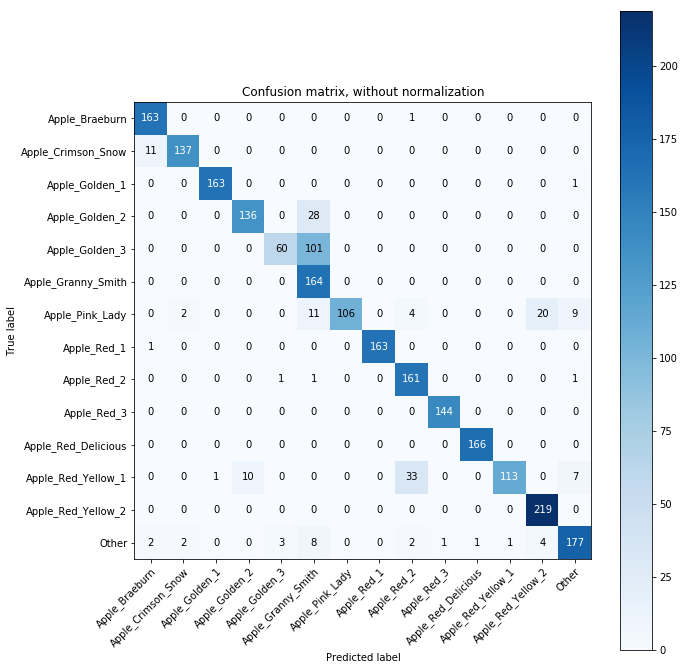

In [61]:
plot_confusion_matrix(np.array(true_classes),np.array(predicted_classes),output_classes)